/tmp/ipython-input-513699807.py:410: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


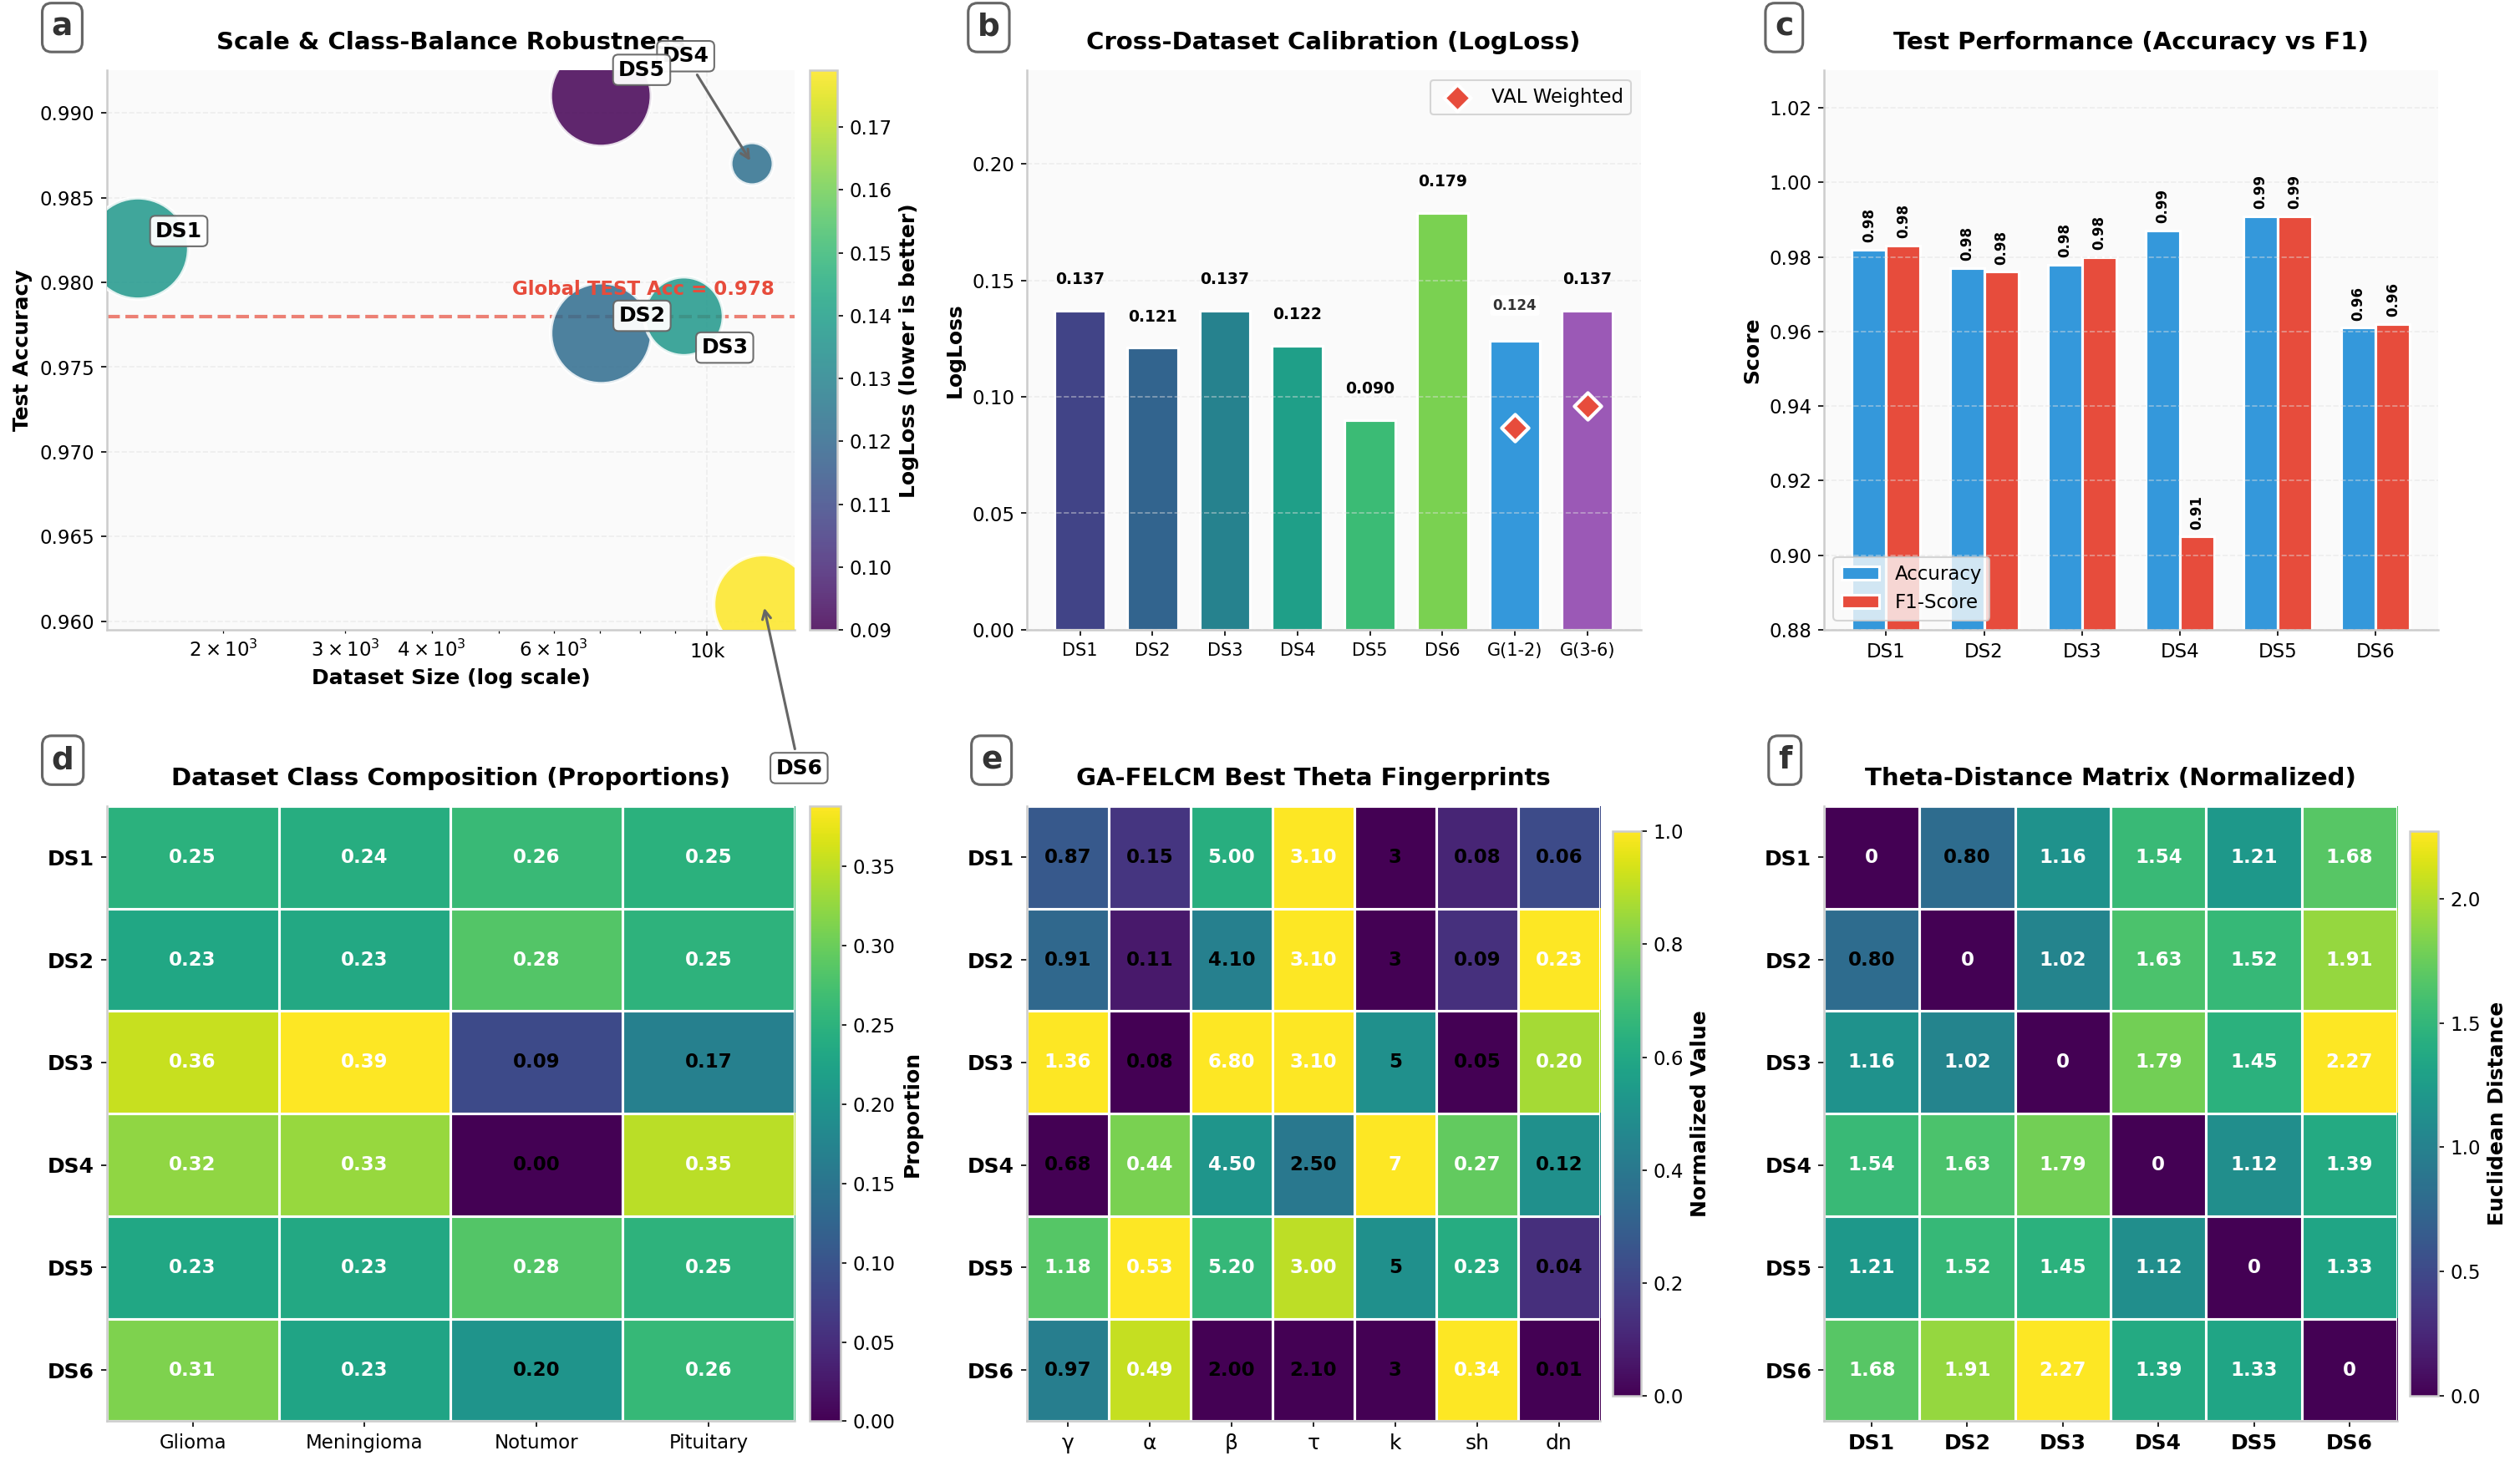

Saved: FedGCFNet_ExternalValidation_Dashboard.png
Saved: FedGCFNet_ExternalValidation_Dashboard.pdf


In [15]:
# ============================================================
# FedGCF-Net External Validation Dashboard
# FINAL FIX v6: VAL markers positioned BELOW the bar values
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter

try:
    get_ipython().run_line_magic("matplotlib", "inline")
except Exception:
    pass

# -----------------------------
# (1) Input: Dataset sizes + class counts
# -----------------------------
classes = ["glioma", "meningioma", "notumor", "pituitary"]

ds_counts = {
    "DS1": {"size": 1505,  "glioma": 373,  "meningioma": 363,  "notumor": 396,  "pituitary": 373},
    "DS2": {"size": 7031,  "glioma": 1621, "meningioma": 1646, "notumor": 2000, "pituitary": 1764},
    "DS3": {"size": 9257,  "glioma": 3293, "meningioma": 3593, "notumor": 811,  "pituitary": 1560},
    "DS4": {"size": 11615, "glioma": 3768, "meningioma": 3806, "notumor": 0,    "pituitary": 4041},
    "DS5": {"size": 7023,  "glioma": 1621, "meningioma": 1645, "notumor": 2000, "pituitary": 1757},
    "DS6": {"size": 12064, "glioma": 3773, "meningioma": 2729, "notumor": 2432, "pituitary": 3130},
}

test_metrics = {
    "DS1": {"acc": 0.982, "f1": 0.983, "logloss": 0.137},
    "DS2": {"acc": 0.977, "f1": 0.976, "logloss": 0.121},
    "DS3": {"acc": 0.978, "f1": 0.980, "logloss": 0.137},
    "DS4": {"acc": 0.987, "f1": 0.905, "logloss": 0.122},
    "DS5": {"acc": 0.991, "f1": 0.991, "logloss": 0.090},
    "DS6": {"acc": 0.961, "f1": 0.962, "logloss": 0.179},
}

global_summaries = {
    "VAL_(DS1-DS2)_Weighted": {"acc": 0.969, "logloss": 0.139},
    "TEST_(DS1-DS2)_Weighted": {"acc": 0.978, "logloss": 0.124},
    "VAL_(DS3-DS6)_Weighted": {"acc": 0.983, "logloss": 0.132},
    "TEST_(DS3-DS6)_Weighted": {"acc": 0.978, "logloss": 0.137},
}

theta = {
    "DS1": [0.87, 0.15, 5.0, 3.1, 3, 0.08, 0.06],
    "DS2": [0.91, 0.11, 4.1, 3.1, 3, 0.09, 0.23],
    "DS3": [1.36, 0.08, 6.8, 3.1, 5, 0.05, 0.20],
    "DS4": [0.68, 0.44, 4.5, 2.5, 7, 0.27, 0.12],
    "DS5": [1.18, 0.53, 5.2, 3.0, 5, 0.23, 0.04],
    "DS6": [0.97, 0.49, 2.0, 2.1, 3, 0.34, 0.01],
}
theta_cols = ["γ", "α", "β", "τ", "k", "sh", "dn"]

ds_list = ["DS1", "DS2", "DS3", "DS4", "DS5", "DS6"]

df_counts = pd.DataFrame.from_dict(ds_counts, orient="index").loc[ds_list]
df_metrics = pd.DataFrame.from_dict(test_metrics, orient="index").loc[ds_list]
df_theta = pd.DataFrame.from_dict(theta, orient="index", columns=theta_cols).loc[ds_list]

prop = df_counts[classes].div(df_counts["size"], axis=0).fillna(0.0)

def entropy(p_row):
    p = np.array(p_row, dtype=float)
    p = p[p > 0]
    if len(p) == 0:
        return 0.0
    return float(-(p * np.log2(p)).sum())

prop_entropy = prop.apply(entropy, axis=1)

theta_norm = df_theta.copy().astype(float)
for c in theta_cols:
    col = theta_norm[c].values.astype(float)
    mn, mx = np.nanmin(col), np.nanmax(col)
    if np.isclose(mx - mn, 0):
        theta_norm[c] = 0.5
    else:
        theta_norm[c] = (col - mn) / (mx - mn)

T = theta_norm.values
dist = np.sqrt(((T[:, None, :] - T[None, :, :]) ** 2).sum(axis=2))
df_dist = pd.DataFrame(dist, index=ds_list, columns=ds_list)

plt.style.use('default')

plt.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "font.size": 12,
    "font.family": "sans-serif",
    "axes.titlesize": 14,
    "axes.titleweight": "bold",
    "axes.labelsize": 12,
    "axes.labelweight": "bold",
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.facecolor": "#FAFAFA",
    "figure.facecolor": "#FFFFFF",
    "axes.edgecolor": "#CCCCCC",
    "axes.linewidth": 1.2,
    "grid.color": "#E0E0E0",
    "grid.linewidth": 0.8,
})

def fmt_thousands(x, _):
    if x >= 1000:
        return f"{int(x/1000)}k"
    return f"{int(x)}"

label_offsets = {
    "DS1": (10, 10),
    "DS2": (10, 10),
    "DS3": (10, -18),
    "DS4": (-80, 15),
    "DS5": (10, 15),
    "DS6": (10, -20),
}

ds_colors = plt.cm.tab10(np.linspace(0, 1, 6))

fig = plt.figure(figsize=(24, 14), facecolor='white')
gs = GridSpec(2, 3, figure=fig, width_ratios=[1.2, 1.0, 1.0], height_ratios=[1.0, 1.1],
              hspace=0.30, wspace=0.28)

def add_panel_label(ax, label, x=-0.08, y=1.05):
    ax.text(x, y, label, transform=ax.transAxes, fontsize=18, fontweight='bold',
            va='bottom', ha='left', color='#333333',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                      edgecolor='#666666', linewidth=1.5))

# =============================
# (a) Bubble scatter
# =============================
axA = fig.add_subplot(gs[0, 0])

x = df_counts["size"].values.astype(float)
y = df_metrics["acc"].values.astype(float)
c = df_metrics["logloss"].values.astype(float)

ent = prop_entropy.values
ent_scaled = 600 + 2800 * (ent - ent.min()) / max(1e-9, (ent.max() - ent.min()))

sc = axA.scatter(
    x, y,
    s=ent_scaled,
    c=c,
    cmap="viridis",
    alpha=0.85,
    edgecolor='white',
    linewidth=2,
    zorder=3
)

axA.set_xscale("log")
axA.xaxis.set_major_formatter(FuncFormatter(fmt_thousands))
axA.grid(True, linestyle="--", alpha=0.5, zorder=0)
axA.set_title("Scale & Class-Balance Robustness", pad=12)
axA.set_xlabel("Dataset Size (log scale)")
axA.set_ylabel("Test Accuracy")

axA.axhline(global_summaries["TEST_(DS1-DS2)_Weighted"]["acc"],
            linestyle="--", linewidth=2, alpha=0.7, color='#E74C3C')
axA.text(
    0.97, global_summaries["TEST_(DS1-DS2)_Weighted"]["acc"] + 0.001,
    "Global TEST Acc = 0.978",
    transform=axA.get_yaxis_transform(),
    ha="right", va="bottom", fontsize=11, fontweight='bold', color='#E74C3C'
)

for i, name in enumerate(ds_list):
    dx, dy = label_offsets.get(name, (10, 10))

    if name == "DS4":
        axA.annotate(
            name,
            xy=(x[i], y[i]),
            xytext=(x[i] - 3000, y[i] + 0.006),
            fontsize=12, fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="#666666", alpha=0.95),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0',
                          color='#666666', lw=1.5),
            zorder=10
        )
    elif name == "DS6":
        axA.annotate(
            name,
            xy=(x[i], y[i]),
            xytext=(x[i] + 500, y[i] - 0.010),
            fontsize=12, fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="#666666", alpha=0.95),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0',
                          color='#666666', lw=1.5),
            zorder=10
        )
    else:
        axA.annotate(
            name,
            (x[i], y[i]),
            textcoords="offset points",
            xytext=(dx, dy),
            ha="left" if dx > 0 else "right",
            va="center",
            fontsize=12, fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="#666666", alpha=0.95),
            zorder=10
        )

cbA = fig.colorbar(sc, ax=axA, fraction=0.046, pad=0.02)
cbA.set_label("LogLoss (lower is better)")

add_panel_label(axA, "a")

# =============================
# (b) LogLoss bars - MARKERS BELOW TEXT
# =============================
axB = fig.add_subplot(gs[0, 1])

bars_names = ["DS1", "DS2", "DS3", "DS4", "DS5", "DS6", "G(1-2)", "G(3-6)"]
bars_vals = list(df_metrics["logloss"].values) + [
    global_summaries["TEST_(DS1-DS2)_Weighted"]["logloss"],
    global_summaries["TEST_(DS3-DS6)_Weighted"]["logloss"],
]

xpos = np.arange(len(bars_names))
bar_colors = list(plt.cm.viridis(np.linspace(0.2, 0.8, 6))) + ['#3498DB', '#9B59B6']

bars = axB.bar(xpos, bars_vals, color=bar_colors, edgecolor='white', linewidth=1.5, width=0.7)

# Draw text labels first
for idx, (rect, val) in enumerate(zip(bars, bars_vals)):
    height = rect.get_height()
    if idx == 6:  # G(1-2) with 0.124
        axB.text(rect.get_x() + rect.get_width()/2, height + 0.012,
                 f"{val:.3f}", ha="center", va="bottom",
                 fontsize=8, fontweight="bold", color='#333333',
                 bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='none', alpha=0.9),
                 zorder=15)
    else:
        axB.text(rect.get_x() + rect.get_width()/2, height + 0.010,
                 f"{val:.3f}", ha="center", va="bottom", fontsize=9, fontweight="bold",
                 rotation=0, zorder=12)

# FIXED: Position VAL markers BELOW the text - subtract offset from bar height
val_data = [
    (6, global_summaries["VAL_(DS1-DS2)_Weighted"]["logloss"],
     global_summaries["TEST_(DS1-DS2)_Weighted"]["logloss"]),
    (7, global_summaries["VAL_(DS3-DS6)_Weighted"]["logloss"],
     global_summaries["TEST_(DS3-DS6)_Weighted"]["logloss"])
]

marker_positions_x = []
marker_positions_y = []

for x_idx, val_y, test_y in val_data:
    # Position marker BETWEEN the bar top and the text
    # Place it at 2/3 of the way up the bar height
    marker_y = test_y * 0.70  # 70% of bar height - clearly visible below text
    marker_positions_x.append(x_idx)
    marker_positions_y.append(marker_y)

# Plot diamond markers at calculated positions
axB.scatter(marker_positions_x, marker_positions_y, marker="D", s=120, c='#E74C3C',
            edgecolor='white', linewidth=2, zorder=10, label="VAL Weighted")

axB.set_xticks(xpos)
axB.set_xticklabels(bars_names, rotation=0, fontsize=10)
axB.set_ylabel("LogLoss")
axB.set_title("Cross-Dataset Calibration (LogLoss)", pad=12)
axB.grid(True, axis="y", linestyle="--", alpha=0.5, zorder=0)
axB.set_ylim(0, 0.24)
axB.legend(loc="upper right", frameon=True)

add_panel_label(axB, "b")

# =============================
# (c) Accuracy vs F1
# =============================
axC = fig.add_subplot(gs[0, 2])

acc = df_metrics["acc"].values
f1 = df_metrics["f1"].values
xx = np.arange(len(ds_list))
w = 0.35

bar1 = axC.bar(xx - w/2, acc, width=w, label="Accuracy", color='#3498DB',
               edgecolor='white', linewidth=1.5)
bar2 = axC.bar(xx + w/2, f1, width=w, label="F1-Score", color='#E74C3C',
               edgecolor='white', linewidth=1.5)

for r, v in zip(bar1, acc):
    axC.text(r.get_x() + r.get_width()/2, v + 0.002, f"{v:.2f}",
             ha="center", va="bottom", fontsize=8, fontweight="bold",
             rotation=90)
for r, v in zip(bar2, f1):
    axC.text(r.get_x() + r.get_width()/2, v + 0.002, f"{v:.2f}",
             ha="center", va="bottom", fontsize=8, fontweight="bold",
             rotation=90)

axC.set_xticks(xx)
axC.set_xticklabels(ds_list, fontsize=11)
axC.set_ylim(0.88, 1.03)
axC.set_ylabel("Score")
axC.set_title("Test Performance (Accuracy vs F1)", pad=12)
axC.grid(True, axis="y", linestyle="--", alpha=0.5)
axC.legend(loc="lower left", frameon=True)

add_panel_label(axC, "c")

# =============================
# (d) Heatmap: class composition
# =============================
axD = fig.add_subplot(gs[1, 0])

imD = axD.imshow(prop.values, aspect="auto", interpolation="nearest", cmap="viridis")
axD.set_title("Dataset Class Composition (Proportions)", pad=12)
axD.set_xticks(np.arange(len(classes)))
axD.set_xticklabels([c.capitalize() for c in classes], rotation=0, fontsize=11)
axD.set_yticks(np.arange(len(ds_list)))
axD.set_yticklabels(ds_list, fontsize=12, fontweight="bold")

for i in range(prop.shape[0]):
    for j in range(prop.shape[1]):
        val = prop.values[i, j]
        text_color = "white" if val > 0.22 else "black"
        axD.text(j, i, f"{val:.2f}", ha="center", va="center",
                 fontsize=11, fontweight="bold", color=text_color)

cbD = fig.colorbar(imD, ax=axD, fraction=0.046, pad=0.02)
cbD.set_label("Proportion")

for i in range(prop.shape[0] + 1):
    axD.axhline(i - 0.5, color='white', linewidth=1.5)
for j in range(prop.shape[1] + 1):
    axD.axvline(j - 0.5, color='white', linewidth=1.5)

add_panel_label(axD, "d")

# =============================
# (e) Heatmap: θ fingerprints
# =============================
axE = fig.add_subplot(gs[1, 1])

imE = axE.imshow(theta_norm.values, aspect="auto", interpolation="nearest",
                 cmap="viridis", vmin=0, vmax=1)
axE.set_title("GA-FELCM Best Theta Fingerprints", pad=12)
axE.set_xticks(np.arange(len(theta_cols)))
axE.set_xticklabels(theta_cols, rotation=0, fontsize=12)
axE.set_yticks(np.arange(len(ds_list)))
axE.set_yticklabels(ds_list, fontsize=12, fontweight="bold")

raw = df_theta.values
for i in range(raw.shape[0]):
    for j in range(raw.shape[1]):
        txt = f"{raw[i, j]:.2f}" if theta_cols[j] != "k" else f"{int(raw[i, j])}"
        valn = theta_norm.values[i, j]
        text_color = "white" if valn > 0.5 else "black"
        axE.text(j, i, txt, ha="center", va="center",
                 fontsize=11, fontweight="bold", color=text_color)

cbE = fig.colorbar(imE, ax=axE, fraction=0.046, pad=0.02)
cbE.set_label("Normalized Value")

for i in range(theta_norm.shape[0] + 1):
    axE.axhline(i - 0.5, color='white', linewidth=1.5)
for j in range(theta_norm.shape[1] + 1):
    axE.axvline(j - 0.5, color='white', linewidth=1.5)

add_panel_label(axE, "e")

# =============================
# (f) θ-distance matrix
# =============================
axF = fig.add_subplot(gs[1, 2])

imF = axF.imshow(df_dist.values, aspect="auto", interpolation="nearest", cmap="viridis")
axF.set_title("Theta-Distance Matrix (Normalized)", pad=12)
axF.set_xticks(np.arange(len(ds_list)))
axF.set_xticklabels(ds_list, rotation=0, fontsize=12, fontweight="bold")
axF.set_yticks(np.arange(len(ds_list)))
axF.set_yticklabels(ds_list, rotation=0, fontsize=12, fontweight="bold")

max_dist = df_dist.values.max()
for i in range(df_dist.shape[0]):
    for j in range(df_dist.shape[1]):
        v = df_dist.values[i, j]
        text_color = "white" if v > (max_dist * 0.45) else "black"
        if i == j:
            axF.text(j, i, "0", ha="center", va="center",
                     fontsize=11, fontweight="bold", color="white")
        else:
            axF.text(j, i, f"{v:.2f}", ha="center", va="center",
                     fontsize=11, fontweight="bold", color=text_color)

cbF = fig.colorbar(imF, ax=axF, fraction=0.046, pad=0.02)
cbF.set_label("Euclidean Distance")

for i in range(df_dist.shape[0] + 1):
    axF.axhline(i - 0.5, color='white', linewidth=1.5)
for j in range(df_dist.shape[1] + 1):
    axF.axvline(j - 0.5, color='white', linewidth=1.5)

add_panel_label(axF, "f")

plt.tight_layout()
plt.show()

out_png = "FedGCFNet_ExternalValidation_Dashboard.png"
out_pdf = "FedGCFNet_ExternalValidation_Dashboard.pdf"
fig.savefig(out_png, bbox_inches="tight", facecolor='white', edgecolor='none')
fig.savefig(out_pdf, bbox_inches="tight", facecolor='white', edgecolor='none')
print(f"Saved: {out_png}")
print(f"Saved: {out_pdf}")